In [1]:
import sys
sys.path.append("..")

from pathlib import Path
import random
import datetime

import pandas as pd
import matplotlib.pyplot as plt

from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas

CACHE_DIR = Path("/georges/memento/BIDS/derivatives/schaeffer/")
PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")

confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
SOFT = False
ATLAS = "schaeffer"
CLEAN_SIGNAL = True
MACRO_LABELS = True

random.seed(1)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
phenotypes = Memento.load_phenotypes(PPATH)

In [3]:
is_converter = phenotypes.declared_dementia.astype(bool).to_list()
days = phenotypes.days_to_onset.to_list()

In [8]:
def days_to_event(phenotypes):
    days_to_event = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes.DEMENCE_DAT
    )
    # This is awful, we need the actual end of followup
    # to compute right censoring. For now let's pretend that
    # existence of M048 implies no right censoring
    
    end_of_followup = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes.INCCONSDAT_D + datetime.timedelta(days=phenotypes.days_to_onset.max())
    )

    last_mri = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes[["M000", "M024"]].max(axis=1)
    )
    

    non_converter_mask = days_to_event.isna()
    right_censored_mask = phenotypes.M048.isna() & non_converter_mask
    
    days_to_event[non_converter_mask] = end_of_followup[non_converter_mask]
    days_to_event[right_censored_mask] = last_mri[right_censored_mask]

    
    return days_to_event

    
phenotypes["days_to_event"] = days_to_event(phenotypes)

In [9]:
from sksurv.datasets import get_x_y

data_x, data_y = get_x_y(
    phenotypes,
    attr_labels=("declared_dementia", "days_to_event"),
    pos_label=1
)

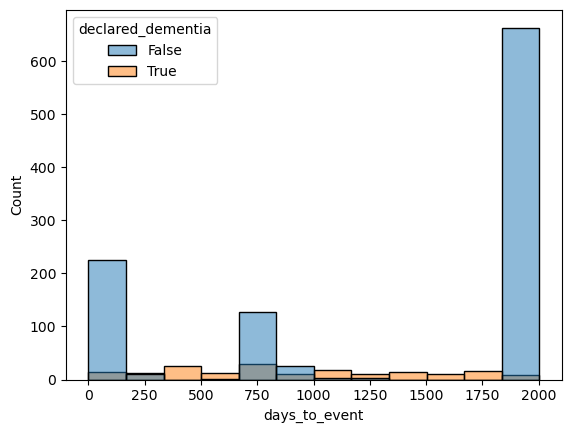

In [10]:
import seaborn as sns
sns.histplot(phenotypes, x="days_to_event", hue="declared_dementia")
plt.show()

In [40]:
days_to_scan = []
for timestep in ("M000", "M024", "M048"):
    days_to_scan.append((phenotypes[timestep] - phenotypes.INCCONSDAT_D).median().days)

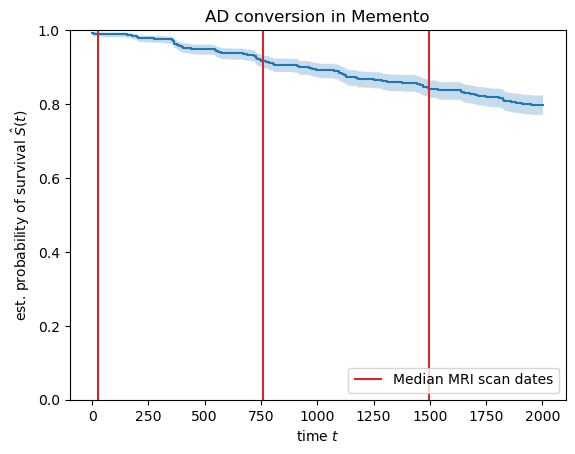

In [42]:
# TODO Give me end of following data PLEASE
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["declared_dementia"], data_y["days_to_event"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)

plt.vlines(days_to_scan, 0, 1, colors="tab:red", label="Median MRI scan dates")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="lower right")
plt.title("AD conversion in Memento")
plt.show()